# ML Course 2024 |  Medical Expenses Prediction Challenge

This notebook should serve as a starting point to work on the project. Please read the project description first.

# Set team ID
Important: set your Team ID here. You can find it in CMS.

In [1]:
team_id = "18"  # put your team id here

# [Colab only] Connect to your Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd "/content/drive/MyDrive/path/to/your/project"

# Imports

[Colab only] Note: if you need to install any packages, run a code cell with content `!pip install packagename`

In [2]:
import os
from itertools import product
from typing import Any

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
from prettytable import PrettyTable
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.linear_model import (
    LassoLars,
    LinearRegression,
    LogisticRegression,
    PassiveAggressiveRegressor,
    Ridge,
    RidgeCV,
)
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
    StandardScaler,
)
from sklearn.svm import SVR, LinearSVR
from skopt.space import Categorical, Integer, Real

# Utility functions

In [3]:
def make_pretty_table(
    data: list, field_names: list[str] | None = None, title: str = ""
) -> PrettyTable:
    """Create a `PrettyTable` from the `data` list with the specified `field_names` and `title`."""
    table = PrettyTable()
    if title:
        table.title = title
    if field_names:
        table.field_names = field_names
    else:
        table.field_names = [f"Column {i+1}" for i in range(len(data[0]))]
    for row in data:
        table.add_row(row)
    return table


def tab_prettytable(table: PrettyTable, tabs: int) -> str:
    """Return the `table` as a string with `'\\t' * tabs` at the beginning of each line."""
    tabs = 0 if tabs < 0 else tabs
    tab_str = "\t" * tabs
    table_str = str(table)
    tabbed = tab_str + table_str.replace("\n", "\n" + tab_str)
    return tabbed


def compute_scores(y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
    """Returns RMSE, MAE, Median SE, Median AE, and R^2 scores for the given true and predicted
    values, in that order."""
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # These might also be helpful to look at. Think about why!
    # Median Squared Error
    medse = np.sqrt(np.median((y_true - y_pred) ** 2))

    # Median Absolute Error
    medae = np.median(abs(y_true - y_pred))

    # R^2 score
    r2 = r2_score(y_true, y_pred)

    return rmse, mae, medse, medae, r2


def round_values(*values: Any, decimals: int = 3) -> tuple:
    """Return a tuple of the `values` rounded to `decimals` number of decimal places."""
    return tuple(round(v, decimals) for v in values)

# Load Data

In a first step, we load the provided training data from the csv file

In [4]:
df_train = pd.read_csv("data/train.csv")
print("The loaded dataset has {} rows and {} columns".format(df_train.shape[0], df_train.shape[1]))

The loaded dataset has 15000 rows and 110 columns


In [5]:
df_train.head()

,RACE,SEX,PANEL,WEIGHT,STUDENT_STAT,MIL_ACTIV_DUTY,HON_DISCHARGE,HEALTH_STAT,MENTAL_HLTH,CHRON_BRONCH,...,NUM_PRESCR_MEDS,DIFFIC_HEAR,DIFFIC_SEE,SMOK,OVR_FEEL_14,MENTAL_HLTH_SCR,PHY_HLTH_SCR,OVR_FEEL_30,TOT_MED_EXP,UTILIZATION
0,Non-White,1,19,7205.036720,-1,2,2,2,2,2,...,0,2,2,2,1,43.82,61.41,3,0,LOW
1,White,1,20,5501.113581,-1,4,2,1,1,2,...,12,2,2,2,0,60.12,54.80,0,240,LOW
2,White,1,20,16797.708379,-1,4,1,3,1,2,...,20,2,2,2,0,60.35,30.08,0,791,LOW
3,Non-White,2,19,3605.218411,-1,2,2,3,3,2,...,20,2,2,2,0,58.32,50.22,0,272,LOW
4,Non-White,1,19,11223.127404,1,2,2,1,2,2,...,3,2,2,2,0,62.39,56.71,0,1264,LOW


# Data exploration

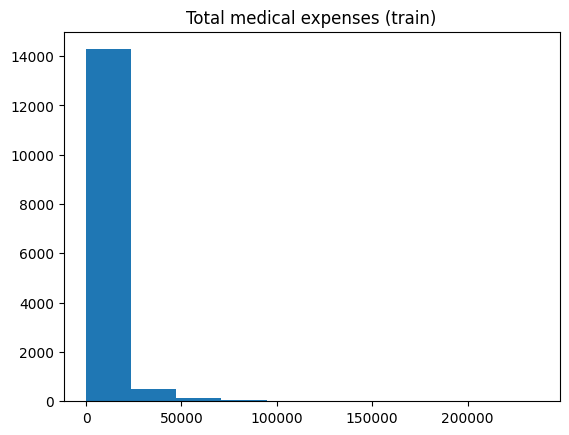

In [6]:
# TODO: explore the data thoroughly, i.e. look for missing values, plot feature histograms, etc

# This is a (rather bad) plot to get you started:
plt.hist(df_train["TOT_MED_EXP"])
plt.title("Total medical expenses (train)")
plt.show()

In [7]:
df_train.describe

<bound method NDFrame.describe of             RACE  SEX  PANEL        WEIGHT  STUDENT_STAT  MIL_ACTIV_DUTY  \
0      Non-White    1     19   7205.036720            -1               2   
1          White    1     20   5501.113581            -1               4   
2          White    1     20  16797.708379            -1               4   
3      Non-White    2     19   3605.218411            -1               2   
4      Non-White    1     19  11223.127404             1               2   
...          ...  ...    ...           ...           ...             ...   
14995  Non-White    1     19  19429.034502            -1               2   
14996  Non-White    2     19   2808.751509            -1               2   
14997  Non-White    2     20  12237.098636            -1               2   
14998  Non-White    2     20   5370.704372            -1               2   
14999  Non-White    1     20   6685.613193            -1               2   

       HON_DISCHARGE  HEALTH_STAT  MENTAL_HLTH  CHRON

In [8]:
# Handling missing values
total_missing_values = df_train.isnull().sum().sum()
print(f"Total number of missing values: {total_missing_values}")

Total number of missing values: 0


In [9]:
# Split into features and target for regression and classification
X = df_train.drop(columns=["TOT_MED_EXP", "UTILIZATION"])
y_regression = df_train["TOT_MED_EXP"]
y_classification = df_train["UTILIZATION"]

In [10]:
# here, identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
# categorical_cols.remove("RACE")  # Exclude 'RACE' from categorical columns

print("Numerical: ", numerical_cols)
print("Categorical: ", categorical_cols)

Numerical:  ['SEX', 'PANEL', 'WEIGHT', 'STUDENT_STAT', 'MIL_ACTIV_DUTY', 'HON_DISCHARGE', 'HEALTH_STAT', 'MENTAL_HLTH', 'CHRON_BRONCH', 'JNT_PAIN', 'PREGNT', 'WALK_LIM', 'ACTIV_LIM', 'SOCIAL_LIM', 'COGNTV_LIM', 'EMPLYMT', 'REGION', 'MARITAL_STAT', 'AGE', 'POVRTY_CAT', 'INSUR_COV', 'TOT_INCOME', 'BM_IDX', 'MULT_HIGHBP', 'HOUSEWRK_LIM', 'SCHOOL_LIM', 'ADV_NO_FAT_FOOD', 'ADV_EXERCISE_MORE', 'ADV_DNTL_CKP', 'FREQ_DNTL_CKP', 'RSN_NO_DNTL_CKP', 'RSN_NO_MED_CKP', 'EMPLYR_INS', 'DOC_CK_BP', 'TAKE_RISK', 'NUM_DEP_OUT_REP_UNT', 'ADV_BOOST_SEAT', 'WHEN_ADV_BOOST_SEAT', 'FEEL_DEPRS', 'ADV_NO_SMKG', 'AGE_DIAG_ADHD', 'CHILD_SUPP', 'PROB_WKIDS', 'PROB_WBHV', 'WEAR_SEATBLT', 'PUB_ASST', 'EDU_DEG', 'SPOUSE_PRSNT', 'TAX_FORM_TYP', 'FOOD_STMP_MNTHS', 'FOOD_STMP_VAL', 'WHEN_ADV_LAP_BLT', 'EDU_YRS', 'WHEN_LST_ASTHMA', 'FAM_INCOME', 'DELAY_PRESCR_MED', 'ADV_LAP_BLT', 'ADV_EAT_HLTHY', 'DOC_TIM_ALN', 'POVRTY_LEV', 'APPT_REG_MEDCARE', 'LOST_ALL_TEETH', 'PROB_BILL_PAY', 'ASPRN_REG', 'OCCUP', 'DIFF_ERRND_ALN', '

# Linear regression

In this part, we will solve an linear regression task to predict our target `TOT_MED_EXP`, i.e. total medical expences, using the other features.


In its simplest form, predictions of a linear regression model can be summarized as

$$
\hat{y} = \mathbf{w}^T \mathbf{x} = f(\mathbf{x},\mathbf{w})
$$

which can be optimized using the cost function

$$
\mathbf{w}^{*}=\underset{\mathbf{w}}{\arg \min } \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-f\left(\mathbf{x}_{i}, \mathbf{w}\right)\right)^{2}
$$

### Process the data

In [11]:
# Filter out non-positive values from both X and y_regression
# TODO: We gotta deal with the 0 values in the target variable
# mask = y_regression > 0

# X = X[mask]
# y_regression = y_regression[mask]

print("The dataset now has {} rows and {} columns".format(X.shape[0], X.shape[1]))

# Split X and y for training and validation purposes
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

The dataset now has 15000 rows and 108 columns


### Train a linear regression model

In [12]:
def available_param_grids_for(model_name: str, grid_search_type: str) -> dict:
    """Get the parameter grid for the specified model and grid search type.

    Parameters
    ----------
    model_name : Any
        The name of the model to get the parameter grid for.
    grid_search_type : str
        The type of grid search to get the parameter grid for.

    Returns
    -------
    dict
        The parameter grid for the specified model and grid search type.
    """
    param_grids = {
        "LinearRegression": {
            "grid": {"fit_intercept": [True, False]},
            "bayes": {"fit_intercept": Categorical([True, False])},
        },
        "Ridge": {
            "grid": {
                "alpha": [0.0005, 0.1, 1.0, 10.0],
                "fit_intercept": [True, False],
            },
            "bayes": {
                "alpha": Real(0.0001, 100, prior="log-uniform"),
                "fit_intercept": Categorical([True, False]),
            },
        },
        "Lasso": {
            "grid": {
                "alpha": [0.0005, 0.1, 1.0, 10.0],
                "fit_intercept": [True, False],
            },
            "bayes": {
                "alpha": Real(0.0001, 100, prior="log-uniform"),
                "fit_intercept": Categorical([True, False]),
            },
        },
        "LassoLars": {
            "grid": {
                "alpha": [0.0005, 0.1, 1.0, 10.0],
                "fit_intercept": [True, False],
                "positive": [True, False],
                "jitter": [0.01, 0.1, 0.5],
            },
            "bayes": {
                "alpha": Real(0.0001, 100, prior="log-uniform"),
                "fit_intercept": Categorical([True, False]),
            },
        },
        "KernelRidge": {
            "grid": {
                "alpha": [0.0005, 0.1, 1.0, 10.0],
                "kernel": ["linear", "poly", "rbf"],
                "degree": [2, 3],
                "gamma": ["scale", "auto"],
            },
            "bayes": {
                "alpha": Real(0.0001, 100, prior="log-uniform"),
                "kernel": Categorical(["linear", "poly", "rbf"]),
                "degree": Integer(2, 3),
                "gamma": Categorical(["scale", "auto"]),
            },
        },
        "TweedieRegressor": {
            "grid": {
                "power": np.linspace(1.0, 2.0, 10),
                "alpha": np.logspace(-3, 1, 10),
                "link": ["log", "identity"],
                "max_iter": [5000],
            },
            "bayes": {
                "power": Real(1.0, 2.0),
                "alpha": Real(1e-3, 10, prior="log-uniform"),
                "link": Categorical(["log", "identity"]),
                "max_iter": Categorical([5000]),
            },
        },
        "LGBMRegressor": {
            "grid": {
                "num_leaves": [31, 127],
                "learning_rate": [0.01, 0.1],
                "n_estimators": [20, 40],
            },
            "bayes": {
                "num_leaves": Integer(31, 127),
                "learning_rate": Real(0.01, 0.1, prior="log-uniform"),
                "n_estimators": Integer(20, 40),
            },
        },
        "GammaRegressor": {
            "grid": {
                "alpha": np.linspace(0.000001, 1, 10),
                "fit_intercept": [True, False],
                "solver": ["lbfgs", "newton-cholesky"],
                "max_iter": [1000, 5000],
            },
            "bayes": {
                "alpha": Real(0.000001, 1, prior="log-uniform"),
                "fit_intercept": Categorical([True, False]),
                "solver": Categorical(["lbfgs", "newton-cholesky"]),
                "max_iter": Categorical([1000, 5000]),
            },
        },
        "PoissonRegressor": {
            "grid": {
                "alpha": np.logspace(-3, 1, 10),
                "fit_intercept": [True, False],
            },
            "bayes": {
                "alpha": Real(1e-3, 10, prior="log-uniform"),
                "fit_intercept": Categorical([True, False]),
            },
        },
        "PassiveAggressiveRegressor": {
            "grid": {
                "C": [0.1, 1, 10, 100, 1000, 100000],
                "fit_intercept": [True, False],
                "max_iter": [1000, 5000],
                "loss": ["epsilon_insensitive", "squared_epsilon_insensitive"],
            },
            "bayes": {
                "C": Real(0.1, 100000, prior="log-uniform"),
                "fit_intercept": Categorical([True, False]),
                "max_iter": Categorical([1000, 5000]),
                "loss": Categorical(["epsilon_insensitive", "squared_epsilon_insensitive"]),
            },
        },
        "GradientBoostingRegressor": {
            "grid": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.1],
                "max_depth": [3, 5, 7],
            },
            "bayes": {
                "n_estimators": Integer(100, 300),
                "learning_rate": Real(0.01, 0.1, prior="log-uniform"),
                "max_depth": Integer(3, 7),
            },
        },
        "SVR": {
            "grid": {
                "C": [0.01, 0.1, 0.5, 1, 10, 100],
                "kernel": ["linear", "rbf", "poly"],
                "gamma": [0.01, 0.05, 0.1, 1, "scale", "auto"],
            },
            "bayes": {
                "C": Real(0.1, 10, prior="log-uniform"),
                "gamma": Real(0.01, 0.1, prior="log-uniform"),
                "kernel": Categorical(["linear", "rbf", "poly"]),
                "degree": Integer(2, 3),
            },
        },
        "LinearSVR": {
            "grid": {
                "C": [0.1, 0.5, 1, 5, 10],
                "intercept_scaling": [1, 10],
                "epsilon": [0.0, 0.1, 0.2, 0.5],
                "tol": [1e-4, 1e-3, 1e-2],
                "C": [0.1, 1.0, 10.0],
                "loss": ["epsilon_insensitive", "squared_epsilon_insensitive"],
                "fit_intercept": [True, False],
                "dual": [True, False],
                "max_iter": [1000, 2000, 5000],
            },
            "bayes": {
                "C": Real(0.1, 10, prior="log-uniform"),
                "intercept_scaling": Integer(1, 10),
                "epsilon": Real(0.0, 1.0, prior="uniform"),
                "tol": Real(1e-4, 1e-1, prior="log-uniform"),
                "loss": Categorical(["epsilon_insensitive", "squared_epsilon_insensitive"]),
                "fit_intercept": Categorical([True, False]),
                "dual": Categorical([True, False]),
                "max_iter": Integer(1000, 5000),
            },
        },
        "LogisticRegression": {
            "grid": {
                "C": [0.1, 1, 10, 100],
                "penalty": ["l1", "l2"],
                "fit_intercept": [True, False],
            },
            "bayes": {
                "C": Real(0.1, 100, prior="log-uniform"),
                "penalty": Categorical(["l1", "l2"]),
                "fit_intercept": Categorical([True, False]),
            },
        },
        "LGBMClassifier": {
            "grid": {
                "num_leaves": [31, 127],
                "learning_rate": [0.01, 0.1],
                "n_estimators": [20, 40],
            },
            "bayes": {
                "num_leaves": Integer(31, 127),
                "learning_rate": Real(0.01, 0.1, prior="log-uniform"),
                "n_estimators": Integer(20, 40),
            },
        },
    }
    if model_name not in param_grids:
        raise ValueError(f"Model {model_name} not found in param_grids.py")
    if grid_search_type not in param_grids[model_name]:
        raise ValueError(f"Grid search type {grid_search_type} not found for model {model_name}")

    return param_grids.get(model_name, {}).get(grid_search_type, None)


def choose_param_grid(model: Any, grid_search_type: str, add_str_to_keys=None) -> dict:
    """Choose a suitable hyperparameter grid to use with `GridSearchCV` or similar object based on
    the model class and the `grid_search_type` to be performed.

    Parameters
    ----------
    model : Any
        The model object to get the hyperparameter grid for. It should be a valid scikit-learn or
        cuML model object.
    grid_search_type : str
        The type of grid search to perform. It should be either 'grid' or 'bayes'.
    add_str_to_keys : str, optional
        A string to add to the beginning of each key in the parameter grid, by default None

    Returns
    -------
    dict
        The hyperparameter grid for the specified model and grid search type
    """
    model_name = model.__class__.__name__
    param_grid = available_param_grids_for(model_name, grid_search_type)

    if add_str_to_keys is not None:
        rewritten_param_grid = {}
        if add_str_to_keys[-2:] == "__":
            add_str_to_keys = add_str_to_keys[:-2]

        if isinstance(param_grid, dict):
            for param, value in param_grid.items():
                rewritten_param_grid[f"{add_str_to_keys}__{param}"] = value
        elif isinstance(param_grid, list):
            rewritten_param_grid = []
            for param_dict in param_grid:
                new_param_dict = {f"{add_str_to_keys}__{k}": v for k, v in param_dict.items()}
                rewritten_param_grid.append(new_param_dict)
        param_grid = rewritten_param_grid

    return param_grid

In [14]:
# Feature selection for linear regression
pipeline = Pipeline(
    steps=[
        (
            "preprocessor",
            ColumnTransformer(
                transformers=[
                    ("num", StandardScaler(), numerical_cols),
                    ("cat", OneHotEncoder(drop="first"), categorical_cols),
                ]
            ),
        ),
        ("poly", PolynomialFeatures(degree=2)),
        ("select", SelectKBest(score_func=f_regression)),
        ("regression", LassoLars()),
    ]
)

param_grid = choose_param_grid(
    pipeline.named_steps["regression"], "grid", add_str_to_keys="regression"
)

# Add the number of features to select to the hyperparameter grid
param_grid["select__k"] = [10]  # Number of top features to select for regression

print(f"Using the following hyperparameter grid for {pipeline.named_steps['regression']}:")
for key, value in param_grid.items():
    print(f"\t{key}: {value}")

print()

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    refit="neg_root_mean_squared_error",
    scoring={
        "neg_root_mean_squared_error": "neg_root_mean_squared_error",
        "neg_median_absolute_error": "neg_median_absolute_error",
        "neg_mean_absolute_error": "neg_mean_absolute_error",
    },
    n_jobs=-2,
    verbose=1,
)

grid_search.fit(X_train_reg, y_train_reg)

best_estimator = grid_search.best_estimator_

print("Best hyperparameters found: ", grid_search.best_params_)

# This won't work if using PCA or Polynomial features before SelectKBest
# print(
#     "Selected features for linear regression:",
#     X.columns[grid_search.best_estimator_.named_steps["select"].get_support(indices=True)],
# )

Using the following hyperparameter grid for LassoLars():
	regression__alpha: [0.0005, 0.1, 1.0, 10.0]
	regression__fit_intercept: [True, False]
	regression__positive: [True, False]
	regression__jitter: [0.01, 0.1, 0.5]
	select__k: [10]

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters found:  {'regression__alpha': 10.0, 'regression__fit_intercept': True, 'regression__jitter': 0.01, 'regression__positive': False, 'select__k': 10}


### Train a model with a `y` transformed

See: https://scikit-learn.org/dev/auto_examples/compose/plot_transformed_target.html

C:\Users\meenu\AppData\Local\Temp\ipykernel_7912\3581623490.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


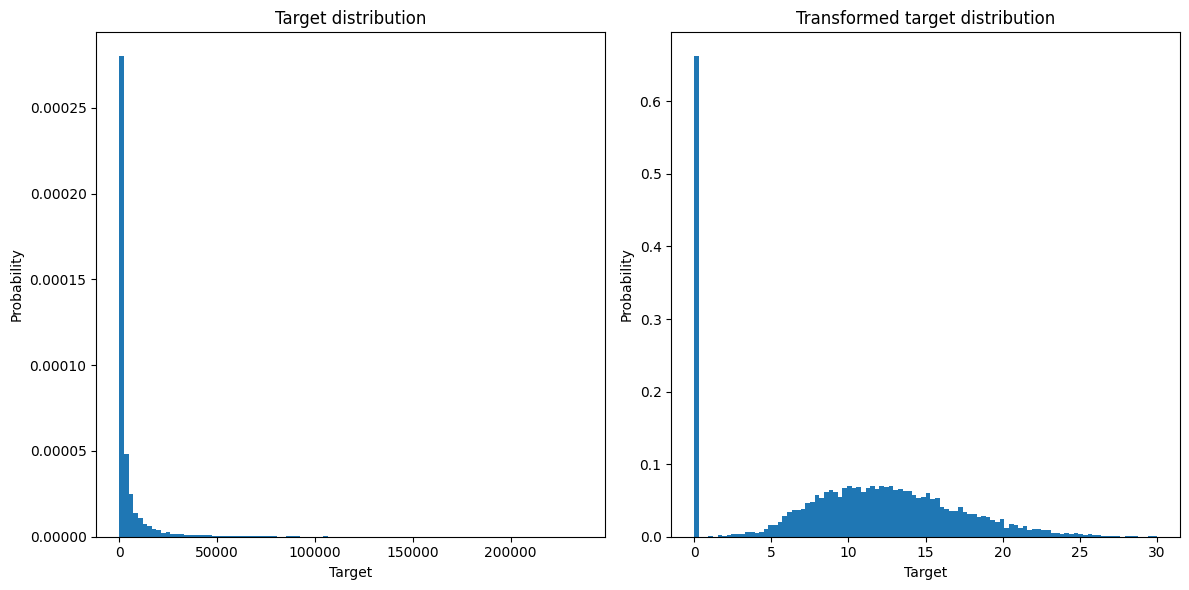

In [13]:
from sklearn.preprocessing import quantile_transform

y_trans = quantile_transform(
    y_regression.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

y_trans = (
    PowerTransformer(method="yeo-johnson", standardize=False)
    .fit_transform(y_regression.to_frame())
    .squeeze()
)

f, (ax0, ax1) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

ax0.hist(y_regression, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")
f.tight_layout()
plt.show()

In [16]:
# Feature selection for linear regression
pipeline_y_transformed = Pipeline(
    steps=[
        (
            "preprocessor",
            ColumnTransformer(
                transformers=[
                    ("num", StandardScaler(), numerical_cols),
                    ("cat", OneHotEncoder(drop="first"), categorical_cols),
                ]
            ),
        ),
        ("poly", PolynomialFeatures(degree=2)),
        ("select", SelectKBest(score_func=f_regression)),
        (
            "regression",
            # TransformedTargetRegressor(
            #     regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1
            # ),
            # TransformedTargetRegressor(
            #     regressor=LassoLars(),
            #     transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
            # ),
            TransformedTargetRegressor(
                regressor=LassoLars(),
                transformer=PowerTransformer(method="yeo-johnson"),
            ),
        ),
    ]
)

param_grid = choose_param_grid(
    pipeline_y_transformed.named_steps["regression"].regressor,
    "grid",
    add_str_to_keys="regression__regressor",
)

# Add the number of features to select to the hyperparameter grid
param_grid["select__k"] = [40, 80]  # Number of top features to select for regression

print(
    f"Using the following hyperparameter grid for {pipeline_y_transformed.named_steps['regression']}:"
)
for key, value in param_grid.items():
    print(f"\t{key}: {value}")

print()

grid_search = GridSearchCV(
    pipeline_y_transformed,
    param_grid=param_grid,
    cv=5,
    refit="neg_root_mean_squared_error",
    scoring={
        "neg_root_mean_squared_error": "neg_root_mean_squared_error",
        "neg_median_absolute_error": "neg_median_absolute_error",
        "neg_mean_absolute_error": "neg_mean_absolute_error",
    },
    n_jobs=-2,
    verbose=1,
)

grid_search.fit(X_train_reg, y_train_reg)

print("Best hyperparameters found: ", grid_search.best_params_)

# Get the best estimator
best_estimator_y_transformed = grid_search.best_estimator_

Using the following hyperparameter grid for TransformedTargetRegressor(regressor=LassoLars(),
                           transformer=PowerTransformer()):
	regression__regressor__alpha: [0.0005, 0.1, 1.0, 10.0]
	regression__regressor__fit_intercept: [True, False]
	regression__regressor__positive: [True, False]
	regression__regressor__jitter: [0.01, 0.1, 0.5]
	select__k: [40, 80]

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best hyperparameters found:  {'regression__regressor__alpha': 0.1, 'regression__regressor__fit_intercept': True, 'regression__regressor__jitter': 0.1, 'regression__regressor__positive': False, 'select__k': 80}


### Evaluate the linear regression model

In [15]:
from sklearn.metrics import PredictionErrorDisplay

regressor_name = best_estimator.named_steps["regression"].__class__.__name__

datasets = {
    "Training data": [X_train_reg, y_train_reg],
    "Validation data": [X_test_reg, y_test_reg],
}

rows = []  # For a PrettyTable
for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = best_estimator.predict(X_i)
    y_pred_transformed = best_estimator_y_transformed.predict(X_i)

    # Compute the regression metrics
    rmse, mae, medse, medae, r2 = compute_scores(y_i, y_pred)
    rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed = (
        compute_scores(y_i, y_pred_transformed)
    )

    # Round them to 3 decimal places
    rmse, mae, medse, medae, r2 = round_values(rmse, mae, medse, medae, r2)
    rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed = (
        round_values(
            rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed
        )
    )

    f, (ax0, ax1) = plt.subplots(2, 2, sharey="row", figsize=(10, 8), constrained_layout=True)

    # plot the actual vs predicted values
    PredictionErrorDisplay.from_predictions(
        y_i,
        y_pred,
        kind="actual_vs_predicted",
        ax=ax0[0],
        scatter_kwargs={"alpha": 0.5},
    )
    PredictionErrorDisplay.from_predictions(
        y_i,
        y_pred_transformed,
        kind="actual_vs_predicted",
        ax=ax0[1],
        scatter_kwargs={"alpha": 0.5},
    )

    # Add the score in the legend of each axis
    for ax, scores in zip(
        [ax0[0], ax0[1]], [[rmse, mae, r2], [rmse_transformed, mae_transformed, r2_transformed]]
    ):
        for name, score in zip(["RMSE", "MAE", "$R^2$"], scores):
            ax.plot([], [], " ", label=f"{name} = {score}")
        ax.legend(loc="upper left")

    ax0[0].set_title(f"{regressor_name}")
    ax0[1].set_title(f"{regressor_name}\nWith $y$ transformed")
    ax0[0].set_xlabel("")
    ax0[1].set_xlabel("")

    # plot the residuals vs the predicted values
    PredictionErrorDisplay.from_predictions(
        y_i,
        y_pred,
        kind="residual_vs_predicted",
        ax=ax1[0],
        scatter_kwargs={"alpha": 0.5},
    )
    PredictionErrorDisplay.from_predictions(
        y_i,
        y_pred_transformed,
        kind="residual_vs_predicted",
        ax=ax1[1],
        scatter_kwargs={"alpha": 0.5},
    )
    ax1[1].set_ylabel("")

    plt.suptitle(f"Regression metrics for {regressor_name} on {split_name.capitalize()}")
    plt.tight_layout()
    plt.show()

    print("\n\n")

    rows.append([split_name, rmse, mae, medse, medae, r2])
    rows.append(
        [
            " (y-transformed)",
            rmse_transformed,
            mae_transformed,
            medse_transformed,
            medae_transformed,
            r2_transformed,
        ]
    )

print(
    make_pretty_table(rows, title="Regression metrics", field_names=["Split", "RMSE", "MAE", "MedSE", "MedAE", "R^2"])
)

NameError: name 'best_estimator' is not defined

### Export test set predictions for regression task

At this point, we can use our model to predict the medical expenses from the test sets. The following cell shows an example on how to do this.

You must save your predictions (`y_hat`) to a file and name the file in the following format:

`<TEAM_ID>__<SPLIT>__reg_pred.npy`

Make sure that:

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_public" during the semester and "test_private" for the final submission. We will write an announcement to CMS once the test_private dataset is available to download.

In [26]:
# Run this to save a file with your predictions on the test set to be submitted
# Specify the dataset split
split = "test_public"  # Replace by 'test_private' for FINAL submission

# Load the test data
df_test = pd.read_csv(f"data/{split}.csv")

y_hat = best_estimator.predict(df_test)

# Save the results with the format <TEAM_ID>__<SPLIT>__reg_pred.npy
folder = "./results"
np.save(
    os.path.join(folder, f"{team_id}__{split}__reg_pred.npy"), y_hat
)  # Note the double underscores '__' in the filename

# Linear classification

In this part, we will train a simple linear classification model to predict our target `UTILIZATION`.


In [22]:
k_classification = 20  # Number of top features to select for classification
select_k_best_classification = SelectKBest(score_func=chi2, k=k_classification)
X_classification_selected = select_k_best_classification.fit_transform(
    X_processed, y_classification
)
selected_features_classification = select_k_best_classification.get_support(indices=True)

NameError: name 'X_processed' is not defined

We will first change our targets (classes: LOW, HIGH) to numeric targets. Then, we solve a logistic regression problem by minimizing the binary cross-entropy function

$$
J(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(p_{\theta}(\hat{y}=1 | \mathbf{x}_i)) + (1 - y_i) \log(p_{\theta}(\hat{y}=0 | \mathbf{x}_i)) \right)
$$

where $y_i \in \{0, 1\}$ and $p_{\theta}(\hat{y}=k | \mathbf{x}_i)$ is the probability assigned by our model to class $k$ having observed features $\mathbf{x}_i$.

0 refers to HIGH, and 1 refers to LOW

### Process the data

In [23]:
df_train = pd.read_csv(f"data/train.csv")

y = df_train["UTILIZATION"]

df_train.drop(columns=["UTILIZATION", "TOT_MED_EXP"])

le = preprocessing.LabelEncoder()
df_test["RACE"] = le.fit_transform(df_test["RACE"])

y = le.fit_transform(y)  # maps HIGH to 0 and LOW to 1

print(f"Original classes {le.classes_}")
print(f"Corresponding numeric classes {le.transform(le.classes_)}")


print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}", f", unique entries in y: {np.unique(y)}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# These hyperparameters are just placeholders, choosen without much care. For a good LogisticRegression baseline, play with them a bit.
clf = linear_model.LogisticRegression(
    penalty=None,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,  # None, balanced
    random_state=None,
    solver="lbfgs",
    max_iter=1500,
    multi_class="auto",
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)

NameError: name 'preprocessing' is not defined

### Fit the model by using training data

In [ ]:
clf = clf.fit(X_train, y_train)

Now evaluate your model. Check the appendix for details on micro, macro and weighted averaging

In [ ]:
datasets = {"training data": [X_train, y_train], "validation data": [X_val, y_val]}

for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f"\nSplit: {split_name}")

    print(skm.classification_report(y_i, y_pred))

At this point, we can use our model to predict healthcare utilization on the test set.

We again need to follow a specific namim format when saving the predictions. Similarly to before, the name of the file should be `<TEAM_ID>__<SPLIT>__clf_pred.npy`.



In [ ]:
# Run this to save a file with your predictions on the test set to be submitted

split = "test_public"  # replace by 'test_private' for FINAL submission

df_test = pd.read_csv(f"data/{split}.csv")

# Process data
df_test["RACE"] = LabelEncoder().fit_transform(df_test["RACE"])

y_hat = clf.predict(df_test)

# Save the results with the format <TEAM_ID>__<SPLIT>__clf_pred.npy

folder = "./"
np.save(os.path.join(folder, f"{team_id}__{split}__clf_pred.npy"), y_hat)

# Submission to CMS

Put your .npy files for both regression and classification tasks in the same zip file. Please name the file as `<TEAM_ID>.zip` (e.g. `123.zip`) and upload it to CMS system. It is essential that the files inside the .zip are named as follow:

`<TEAM_ID>__<SPLIT>__reg_pred.npy` \
`<TEAM_ID>__<SPLIT>__clf_pred.npy`

Above, `<SPLIT>` should correspond to `test_public` for the leaderboard and `test_private` for the final submission.
As long as the `test_private.csv` data file is not released yet, the zip will contain only two files.


### Appendix: Reminders about macro and micro averaging:

When evaluating a classification model using `skm.classification_report(y_i, y_pred)` as done above, we get a macro and a weighted average.

In the context of computing F1-score, "macro" and "micro" averaging are two commonly used techniques to aggregate the per-class F1-scores.

**Micro-average**: Compute the F1-score globally by counting the total true positives, false negatives, and false positives over all classes, and then calculating precision, recall, and F1-score using these aggregated values.

**Macro-average**: Calculate the F1-score for each class separately, and then take the average of these per-class F1-scores.

The main difference between these two techniques is the way they treat class imbalance. Micro-average treats all classes equally, regardless of their size, while macro-average treats each class equally, regardless of the number of samples in that class.

Micro-average is often used when we care about overall performance across all classes, and we want to give more weight to the performance on larger classes. In contrast, macro-average is often used when we want to evaluate the performance on each class separately and give equal weight to each class.


In addition to micro and macro averaging, there is another common technique for computing the F1-score called **weighted averaging**.

**Weighted averaging** is similar to macro averaging in that it computes the per-class F1-score and then takes the average of these scores. However, unlike macro averaging, weighted averaging takes into account the number of samples in each class when computing the average. Specifically, the weighted average is computed as follows:

- Compute the F1-score for each class separately.
- Compute the weight for each class as the number of samples in that class divided by the total number of samples.
- Compute the weighted average of the per-class F1-scores, where each per-class F1-score is weighted by the weight of that class.

The weighted average is commonly used when the dataset is imbalanced, meaning that some classes have many more samples than others. In such cases, using the simple average (macro-average) would give too much weight to the smaller classes, while using micro-average would give too much weight to the larger classes. The weighted average strikes a balance between these two approaches by giving more weight to the classes with more samples while still taking into account the performance of all classes.


When computing the F1 score for the leaderboard and the final challenge results, we will be using the macro averaging strategy.